<a href="https://colab.research.google.com/github/LeoLelli/AI_KialoProject/blob/main/KialoProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kialo Project**

---



**Goal**: to help a user to join a Kialo discussion

**Approach**: analyze all comments and provide the user with the one with the highest semantic similarity to the user's comment

I use a transformer to do embedding of comments and then cosin similarity to calculate their similarity score. The similarity score indicates whether two texts have similar or more different meanings. 

In [ ]:
#!pip install sentence-transformers
#import
import re
import sys
from sentence_transformers import SentenceTransformer, util
import numpy as np
 
%matplotlib inline
input_file = "ps5-v-xbox-series-xs-whats-better-48036.txt"

# pre-trained transformers: https://docs.google.com/spreadsheets/d/14QplCdTCDwEmTqrn1LH4yrbKvdogK4oQvYO1K1aPR5M/edit#gid=0
model = SentenceTransformer('stsb-distilroberta-base-v2')

In [ ]:
class Comment:
  def __init__(self, level, content, sentiment):
    self.level = level
    self.content = content
    self.sentiment = sentiment
    self.similarity = 0

  def __str__(self):
        return self.level + " " + self.content +" "+ "["+self.sentiment+"]" + " sim:" + str(self.similarity)
  
  def setSimilarity(self, similarity):
        self.similarity = similarity

  def __eq__(self, other):
    if (isinstance(other, Comment)):
      return self.level == other.level

In [ ]:
with open(input_file, 'r') as in_f:
    lines = []
    for line in in_f:
        lines.append(line)

title = lines[0];
del lines[0:2]
comments = []

# split tree level from content
for line in lines:
  splitted_sentence = line.split('. ', 1)
  level = splitted_sentence[0]
  content = splitted_sentence[1]

  # separate Pro or Con from the actual comment
  sentiment = "Neutral"
  if "Pro:" in content or "Con: " in content:
    sentiment = content[0:3]
    content = content[5:]

  # delete links in the content
  content = re.sub(r'http\S+', '', content)
  # delete () and []
  content = content.replace('[','').replace(']','').replace('(','').replace(')','').replace('\n',"")

  c = Comment(level, content, sentiment)
  comments.append(c)

root = comments[0]

Encoding of user comment and comments in discussion txt file + loop to calculate cos similarity

In [ ]:
user_comment = "The PS5 is better because it has many more games and is used by more people."
embedding2 = model.encode(user_comment, convert_to_tensor=True)

for c in comments:
  embedding1 = model.encode(c.content, convert_to_tensor=True)
  c.setSimilarity(util.pytorch_cos_sim(embedding1, embedding2).item())

comments.sort(key=lambda x: x.similarity, reverse=True)

k = 3 # number of comments PRO and CON
print("You should answer to one of these comments:\n")

for c in comments[:k]:
  print(c, end="\n")

#print("similarity", comments[0].similarity)


You should answer to one of these comments:

1.4 The PS5 has a better lineup of games that will be released in the future. [Con] sim:0.7782171368598938
1.3.1 The PS5 offers more exclusive games than the Series X/S. [Con] sim:0.775642454624176
1.1.2 This might indicate that the PS5 is worth more since it is a better console. [Con] sim:0.7517738938331604


## **Method validation**

For each comment X, I compute the similarity list between X and each other comment Y, then I calculate the rank of the real father of X and at the end I print the Mean Reciprocal Rank (MRR) for each class (Pro and Con)

In [ ]:
tot_rank_pro = 0
tot_rank_con = 0
nc = 0
np = 0
father_list = []
similarity_list = []
for c1 in comments:
  if c1 != root:
    embedding1 = model.encode(c1.content, convert_to_tensor=True)
    comments_list = []
    for c2 in comments:
      if c1 != c2:
        embedding2 = model.encode(c2.content, convert_to_tensor=True)
        c2.setSimilarity(util.pytorch_cos_sim(embedding1, embedding2).item())
        comments_list.append(c2)

    comments_list.sort(key=lambda x: x.similarity, reverse=True)
    father = next((x for x in comments_list if x.level == c1.level[:len(c1.level)-2]), None)

    father_list.append([father, c1.sentiment])
    similarity_list.append(comments_list)

    if father in comments_list:
      rank = 1/(comments_list.index(father)+1)
    else:
      rank = 0
    
    if c1.sentiment == "Pro":
      tot_rank_pro = tot_rank_pro + rank
      np = np + 1
    if c1.sentiment == "Con":
      tot_rank_con = tot_rank_con + rank 
      nc = nc + 1

print("MRR for class Pro is ", tot_rank_pro/np)
print("MRR for class Con is ", tot_rank_con/nc)

MRR for class Pro is  0.5416574958563666
MRR for class Con is  0.24525365990246423


The MRR is significantly higher for the Pro class, this is because the similarity between two agreeing comments is reasonably greater.

I plot the frequency of the father within the list of similarity values as k changes, where k is the number of top k elements that I am going to consider within the list

In [ ]:
k = 1
max = 100
freq_list_pro = []
freq_list_con = []
while k < max:
  freq_pro = 0
  freq_con = 0
  np = 0
  nc = 0
  for f, c_list in zip(father_list, similarity_list):
    sim_top_k_list = c_list[:k]
    if f[1] == "Pro":
      if f[0] in sim_top_k_list:
        freq_pro = freq_pro + 1
      np = np + 1

    if f[1] == "Con":
      if f[0] in sim_top_k_list:
        freq_con = freq_con + 1
      nc = nc + 1

  freq_list_pro.append(freq_pro/np)
  freq_list_con.append(freq_con/nc)
  k = k + 1

# print(freq_list_pro)
# print(freq_list_con)

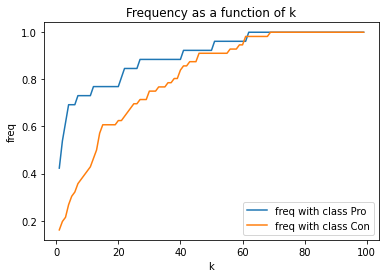

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, max), freq_list_pro, label = "freq with class Pro")
plt.plot(range(1, max), freq_list_con, label = "freq with class Con")
plt.xlabel('k')
plt.ylabel('freq')
plt.title('Frequency as a function of k')
plt.legend()
plt.show()

As we expect, as k increases, so does the frequency of the parent within the list

**Conclusion**

The similarity method seems to work well if the user wants to respond to a comment they agree with (MRR indicates that on average the best comment to respond to is in the top 2 positions) while it works less well if the user's comment disagrees with the one they want to respond to.

The frequency graph also confirms this.